In [1]:
!git clone https://github.com/WaShindeiru/IceCubeNeutrino

Cloning into 'IceCubeNeutrino'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 92 (delta 47), reused 33 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (92/92), 693.42 KiB | 9.50 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [2]:
!cp -r IceCubeNeutrino/* .

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip ./drive/MyDrive/icecube/ice_cube_small.zip

Archive:  ./drive/MyDrive/icecube/ice_cube_small.zip
   creating: ice_cube_small/
  inflating: ice_cube_small/train_meta.parquet  
  inflating: ice_cube_small/test_meta.parquet  
  inflating: ice_cube_small/sensor_geometry.csv  
  inflating: ice_cube_small/sample_submission.parquet  
   creating: ice_cube_small/train_2/
  inflating: ice_cube_small/train_2/batch_3.parquet  
  inflating: ice_cube_small/train_2/batch_2.parquet  
  inflating: ice_cube_small/train_2/batch_1.parquet  
   creating: ice_cube_small/test/
  inflating: ice_cube_small/test/batch_661.parquet  


In [5]:
!unzip ./drive/MyDrive/icecube/iceCube1_result.zip

Archive:  ./drive/MyDrive/icecube/iceCube1_result.zip
   creating: iceCube_result/
  inflating: iceCube_result/model_101.pth  
  inflating: iceCube_result/losses.pickle  
   creating: iceCube_result/weights/
  inflating: iceCube_result/weights/model_34_2025-06-12_11:59:35.pth  
  inflating: iceCube_result/weights/model_101_2025-06-11_18:39:52.pth  
  inflating: iceCube_result/weights/model_34_2025-07-06_16:43:54.pth  
   creating: iceCube_result/results/
  inflating: iceCube_result/results/losses_2025-06-12_11:59:35.pickle  
  inflating: iceCube_result/results/val_losses_2025-07-06_16:43:54.pickle  
  inflating: iceCube_result/results/losses_2025-07-06_16:43:54.pickle  
  inflating: iceCube_result/results/losses_2025-06-11_18:39:52.pickle  


In [6]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from Resnet import resnet34
from Icecube_Dataloader import IceCube_Dataloader, collate_fn

In [7]:
model = resnet34(pretrained = False)
model.fc = nn.Sequential(nn.ReLU(),nn.Linear(in_features=512, out_features=2)) # Changed FC layer for our task
model.load_state_dict(torch.load("./iceCube_result/weights/model_34_2025-07-06_16:43:54.pth", weights_only=True))
model.eval()

ResNet(
  (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
pqfile = './ice_cube_small/train_meta.parquet'
path_batch = './ice_cube_small/train_2/'
geometry = "./ice_cube_small/sensor_geometry.csv"

batch_num=2
lr = 1e-07
num_epochs = 1
batch_size = 16

In [9]:
from torch.utils.data import DataLoader

ice_dataset = IceCube_Dataloader(pqfile, path_batch, geometry, batch_num)
train_dataset = ice_dataset
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn, num_workers=11)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

## Testy resnet34

In [11]:
data_iter = iter(train_dataloader)

In [12]:
first_batch = next(data_iter)
print(f"input tensor shape: {first_batch['input_tensor'].shape}")
print(f"label shape: {first_batch['label'].shape}")
input_tensor = first_batch['input_tensor']
label = first_batch['label'].to(device)

result = model(input_tensor.to(device))

input tensor shape: torch.Size([16, 5, 1, 40574])
label shape: torch.Size([16, 2])


In [13]:
def compare(label, result):
    assert label.shape == result.shape
    x = label.shape[0]
    for i in range(x):
        print(f"Correct: {label[i, :].detach().cpu().numpy()}, predicted: {result[i, :].detach().cpu().numpy()}")

In [14]:
compare(label, result)

Correct: [1.3094674 1.4569385], predicted: [1.9432718 1.6211785]
Correct: [0.36587763 1.5503592 ], predicted: [1.9411682 1.6222512]
Correct: [5.411389  1.8956873], predicted: [1.941958 1.621888]
Correct: [5.7976327 1.5299659], predicted: [1.9411438 1.6209106]
Correct: [1.0795888 1.5558317], predicted: [1.9413433 1.6230792]
Correct: [1.8193924 2.5666716], predicted: [1.9411912 1.6226771]
Correct: [5.2632475 1.8062365], predicted: [1.9405515 1.6202055]
Correct: [3.2348194 1.5699083], predicted: [1.9401101 1.6206259]
Correct: [0.72465396 0.285989  ], predicted: [3.6687455 0.6533731]
Correct: [2.964782  2.3667738], predicted: [1.9404315 1.6204098]
Correct: [4.5529127  0.72191787], predicted: [1.93994   1.6219366]
Correct: [4.4229364 1.1512367], predicted: [1.9417287 1.6219058]
Correct: [1.2908477 2.0225742], predicted: [1.9406784 1.6214216]
Correct: [5.1789494  0.67744726], predicted: [1.939674  1.6233948]
Correct: [3.014161 2.541569], predicted: [1.9410517 1.6236253]
Correct: [2.3294933 0

In [15]:
loss_function = nn.MSELoss().to(device)

In [16]:
temp = loss_function(result.float(),label.float())
print(temp)

tensor(2.6038, device='cuda:0', grad_fn=<MseLossBackward0>)


In [17]:
first_batch = next(data_iter)
print(f"input tensor shape: {first_batch['input_tensor'].shape}")
print(f"label shape: {first_batch['label'].shape}")
input_tensor = first_batch['input_tensor']
label = first_batch['label']

result = model(input_tensor.to(device))

input tensor shape: torch.Size([16, 5, 1, 87])
label shape: torch.Size([16, 2])


In [18]:
compare(label, result)

Correct: [3.459777  1.0682106], predicted: [2.025123  1.5202724]
Correct: [1.8965435 2.0491993], predicted: [1.9362049 1.9598775]
Correct: [6.0062175 1.214638 ], predicted: [2.1355457 1.4227744]
Correct: [5.0591354 2.562436 ], predicted: [1.8409942 1.1934471]
Correct: [2.7769141 2.2501485], predicted: [1.6435096 1.0314233]
Correct: [4.1755357 2.4943383], predicted: [1.9298915 1.6124675]
Correct: [0.8983815 2.4185522], predicted: [2.059038  1.3018634]
Correct: [0.64708006 3.1011517 ], predicted: [1.7246006 1.3444332]
Correct: [3.8278003 1.8901063], predicted: [4.9470963 3.0149207]
Correct: [5.2179646 2.4562387], predicted: [1.6819674 1.4781722]
Correct: [0.8872316 2.9614713], predicted: [1.6635889 1.2632991]
Correct: [0.21549904 2.1214628 ], predicted: [2.025532  1.0502092]
Correct: [1.1592255 0.6585343], predicted: [1.9453425 1.2881979]
Correct: [1.6390312 1.1765193], predicted: [1.8530283 1.4088856]
Correct: [3.0633292 1.3302373], predicted: [1.6013156 1.3908365]
Correct: [1.7164711 2

In [19]:
first_batch = next(data_iter)
print(f"input tensor shape: {first_batch['input_tensor'].shape}")
print(f"label shape: {first_batch['label'].shape}")
input_tensor = first_batch['input_tensor']
label = first_batch['label']

result = model(input_tensor.to(device))

input tensor shape: torch.Size([16, 5, 1, 2409])
label shape: torch.Size([16, 2])


In [20]:
compare(label, result)

Correct: [5.846696  1.0036911], predicted: [1.9564414 1.5924405]
Correct: [4.963914  1.3950213], predicted: [1.9518012 1.6207334]
Correct: [0.30117077 2.9755213 ], predicted: [1.9658602 1.6087359]
Correct: [4.846968  1.8835764], predicted: [1.9299997 1.5993016]
Correct: [4.8862076 1.4305174], predicted: [1.9341797 1.6113985]
Correct: [2.9433856 1.919053 ], predicted: [1.966276  1.5960418]
Correct: [1.0093726  0.67742234], predicted: [1.9543483 1.6130077]
Correct: [1.238611   0.78068054], predicted: [1.9613844 1.6160866]
Correct: [4.3170137 2.7322807], predicted: [1.9983773 1.524832 ]
Correct: [1.0910524 2.373707 ], predicted: [1.9363049 1.5919145]
Correct: [3.950419 1.004591], predicted: [1.9596314 1.6064517]
Correct: [5.4312453 0.7021807], predicted: [1.9457814 1.6259936]
Correct: [5.3268723 1.8123881], predicted: [1.9667528 1.5866517]
Correct: [1.959383   0.35959575], predicted: [2.3481586 1.4557797]
Correct: [1.0658724 1.3521875], predicted: [1.9748458 1.6424314]
Correct: [2.981863 

In [21]:
first_batch = next(data_iter)
print(f"input tensor shape: {first_batch['input_tensor'].shape}")
print(f"label shape: {first_batch['label'].shape}")
input_tensor = first_batch['input_tensor']
label = first_batch['label']

result = model(input_tensor.to(device))

input tensor shape: torch.Size([16, 5, 1, 268])
label shape: torch.Size([16, 2])


In [22]:
compare(label, result)

Correct: [3.8900733 1.3383378], predicted: [1.9009842 1.983601 ]
Correct: [0.2592983 0.8145929], predicted: [1.9570266 1.4739395]
Correct: [1.1266407 2.2128787], predicted: [2.099933  1.6622244]
Correct: [4.757131 1.058703], predicted: [2.0786493 1.5422083]
Correct: [1.1738256  0.78702754], predicted: [2.0022016 1.6516429]
Correct: [2.919115  1.9410143], predicted: [1.9552468 1.4906499]
Correct: [4.6207466 2.3161418], predicted: [1.9363837 1.507259 ]
Correct: [4.774466  0.9987993], predicted: [2.117752  1.3428289]
Correct: [6.1110344 1.9807669], predicted: [1.9070133 1.1122407]
Correct: [2.6108336 1.0625534], predicted: [2.065164  1.5637841]
Correct: [3.957771  1.0070096], predicted: [2.124651  1.5330368]
Correct: [2.6726668 2.0410895], predicted: [2.0424116 1.4704512]
Correct: [0.36459857 2.63065   ], predicted: [1.7399807 1.2873743]
Correct: [5.3023014 1.2770613], predicted: [2.866778  1.0045829]
Correct: [0.68817836 0.8749787 ], predicted: [2.0466657 1.5297725]
Correct: [1.3919259 1

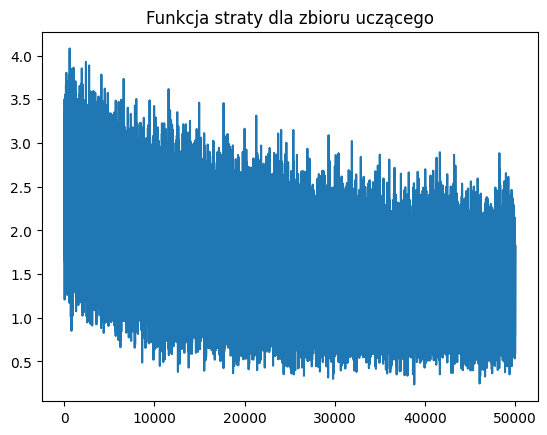

In [25]:
import pickle

with open('./iceCube_result/results/losses_2025-07-06_16:43:54.pickle', 'rb') as f:
    data = pickle.load(f)

plt.figure()
plt.title("Funkcja straty dla zbioru uczącego")
plt.plot(data)

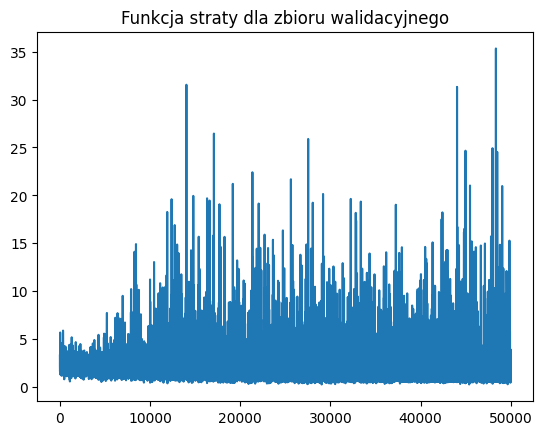

In [26]:
with open('./iceCube_result/results/val_losses_2025-07-06_16:43:54.pickle', 'rb') as f:
    data = pickle.load(f)

plt.figure()
plt.title("Funkcja straty dla zbioru walidacyjnego")
plt.plot(data)

In [27]:
def angles_to_unit_vector(angle_array):
    azimuth = angle_array[:, 0]
    zenith = angle_array[:, 1]

    x = np.sin(zenith) * np.cos(azimuth)
    y = np.sin(zenith) * np.sin(azimuth)
    z = np.cos(zenith)

    return np.stack([x, y, z], axis=1)

In [28]:
import numpy as np

num_of_examples = 100
losses_ = []
residual_cache = []
loss_total = 0.

for i in range(num_of_examples):
    example = next(data_iter)
    input_tensor = example['input_tensor'].to(device)
    label = example['label'].to(device)

    result = model(input_tensor)

    loss_value = loss_function(result.float().cpu(),label.float().cpu())
    losses_.append(loss_value.item())

    temp_result = angles_to_unit_vector(result.cpu().detach().numpy())
    temp_label = angles_to_unit_vector(label.cpu().detach().numpy())

    temp_ = np.clip(np.sum(temp_result * temp_label, axis=1), -1, 1)
    residuals = np.degrees(np.arccos(temp_))
    residual_cache.append(residuals.mean())

print(f"average loss: {np.mean(losses_)}")
print(f"Median loss: {np.median(losses_)} ")

average loss: 4.2651323330402375
Median loss: 2.915509343147278 


## Residuum

In [29]:
residual_ = np.array(residual_cache)
# residual_ = residual_.reshape(-1)
print(residual_.shape)

(100,)


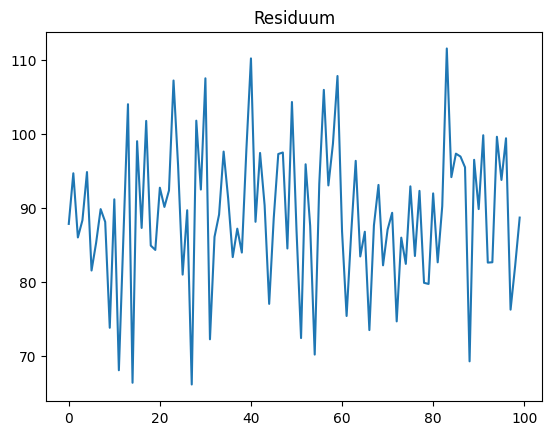

In [30]:
plt.figure()
plt.plot(residual_)
plt.title("Residuum")
plt.show()